## Step 4 - this file runs HashVectorizer on the 10K text; and constructs a pipeline with SVD to run Ridge, Random Forst Regressor to predict the missing governance score values.

In [2]:
#load master and assign train/test for predicting governance score

master = pd.read_csv('master.csv')
#master = master[~master.GOVERNANCE_SCORE.isna()]
master['has_valid_y'] = ~master.GOVERNANCE_SCORE.isna()
master['train'] = master.has_valid_y & (master.index < 400)
master['test'] = master.has_valid_y & (master.index > 400)

In [3]:
#perform hashing vectorizer w/ stop words

STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'})
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
hv = HashingVectorizer(stop_words=STOP_WORDS, ngram_range=(1,1))
#note that kernel dies when ngrams above 1 are included

In [ ]:
#kick off hashing first 1 to set sparse matrix frame

batchSize = 1
temp = master[['Symbol', 'CIK']][0:batchSize]
temp['10K'] = ''

for x in range(batchSize):
    path = '10kfolder/' + str(temp['CIK'][x]) + '_' + temp['Symbol'][x]
    CIK = str(temp['CIK'][x])     
    try:
        with open(path, 'r') as f2:
            temp['10K'][x] = f2.read()
    except:
        temp['10K'][x] = ''
            
hashed_master = hv.fit_transform(temp['10K'])

In [ ]:
#hash vectorizer for remaining obs. (running the above code in batches, accounting for first
#batch that has already been completed) 

for j in range(1, (len(master))//batchSize):
    iters = batchSize*j
    thru = iters+batchSize
    print(f'running{iters}-{thru}')

    temp = master[['Symbol', 'CIK']][iters:thru]
    temp['10K'] = ''

    for x in range(iters, thru):
        path = '10kfolder/' + str(temp['CIK'][x]) + '_' + temp['Symbol'][x]
        CIK = str(temp['CIK'][x])     
        try:
            with open(path, 'r') as f2:
                temp['10K'][x] = f2.read()
        except:
            temp['10K'][x] = ''
            
    hashed_temp = hv.fit_transform(temp['10K'])
    hashed_master = scipy.sparse.vstack((hashed_master, hashed_temp))

In [ ]:
scipy.sparse.save_npz('hashed', hashed_master)

In [3]:
hashed_master = scipy.sparse.load_npz('hashed.npz')

In [4]:
ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(master[['City', 'State', 'Country', 'Sector', 'Industry', 'Exchange']]).toarray()

labels = []
for x in range(len(ohe.categories_)):
    for y in range(len(ohe.categories_[x])):
        labels.append(ohe.categories_[x][y])
            
cat_features = pd.DataFrame(feature_arr, columns=labels)

In [5]:
num_features = master[['ESG_SCORE', 'SOCIAL_SCORE', 'ENERGY_CONSUMPTION_SUB_ISS_SCR', 
                       'RENEWABLE_ENERGY_USE_SUB_ISS_SCR', 'WATER_MANAGEMENT_ISSUE_SCORE', 
                       'WORKFORCE_DIVERSITY_SUB_ISS_SCR', 'Currentprice', 'Marketcap', 
                       'Revenuegrowth', 'Fulltimeemployees']]

In [6]:
master_features = cat_features.merge(num_features, left_index=True, right_index=True)
master_features = master_features.fillna(0)

In [7]:
tfidfFeatureCount = hashed_master.shape[1] 
totFeatures = hashed_master.shape[1] + master_features.shape[1]

tfidf = ColumnTransformer(
    transformers = [
    ('tfidf', TfidfTransformer(), np.arange(tfidfFeatureCount) )],
    remainder='passthrough'
    )

#Standard Scalar - we can use with_mean=False on tfidf as the sparse matrix mean is ~0 
standardScale = ColumnTransformer(
    transformers = [
    ('standardScaleSparse', StandardScaler(with_mean=False), np.arange(tfidfFeatureCount) ),
    ('standardScaleDense', StandardScaler(with_mean=False), np.arange(tfidfFeatureCount, totFeatures) )],
    remainder='passthrough'
    )
    
svd = ColumnTransformer(
    transformers = [
    ('svd', TruncatedSVD(), np.arange(totFeatures) )],
    remainder='passthrough'
    )

pipe = Pipeline([  
    ('tfidf', tfidf),
    ('standardScale', standardScale),
    ('svd', svd),
    #('ranFor', RandomForestRegressor(n_estimators = 100))
    ('ridge', Ridge()) 
    ])

In [8]:
#train+test sets 

X_train = hashed_master[master.train] #383 x 1M
X_test = hashed_master[master.test] #383 x 1M

# append the other features on to the end of the X_train matrix 
X_train = scipy.sparse.hstack((X_train, master_features.loc[master.train].fillna(0).values))
X_test = scipy.sparse.hstack((X_test, master_features.loc[master.test].fillna(0).values))

y_train = master.loc[master.train, 'GOVERNANCE_SCORE'] 
y_test = master.loc[master.test, 'GOVERNANCE_SCORE'] 

In [9]:
parameters = {
    #'ranFor__max_depth': np.linspace(10, 40, 4),
    'svd__svd__n_components': [10, 15],
    'ridge__alpha': [1e-1]
    }

search = GridSearchCV(pipe, parameters, n_jobs=1, verbose=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf',
                                                                         TfidfTransformer(),
                                                                         array([      0,       1,       2, ..., 1048573, 1048574, 1048575]))])),
                                       ('standardScale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardScaleSparse',
                                                                         StandardScaler(with_mean=False),
                                                                         array([      0,       1,       2, ..., 1048573, 1048574, 1048575]))...
       1048975, 1048976, 1048977, 1048978, 1048979, 1048980, 1

In [10]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-0.081):
{'ridge__alpha': 0.1, 'svd__svd__n_components': 10}


In [14]:
predictions = search.predict(X_train.tocsr())

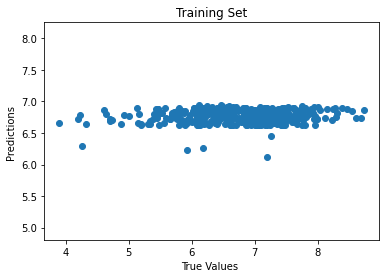

<Figure size 432x288 with 0 Axes>

In [31]:
plt.scatter(y_train, predictions)
plt.title('Training Set')
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.show()
plt.savefig('pred_plot_train.jpg', bbox_inches='tight')

In [17]:
predictionsTest = search.predict(X_test.tocsr())

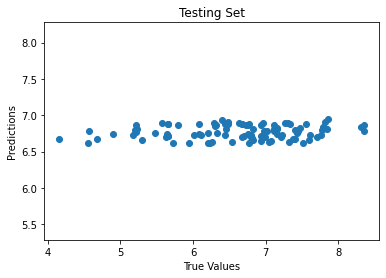

<Figure size 432x288 with 0 Axes>

In [30]:
plt.scatter(y_test, predictionsTest)
plt.title('Testing Set')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.show()
plt.savefig('pred_plot_tst.jpg', bbox_inches='tight');

In [19]:
print(r2_score(y_test,predictionsTest))

-0.01177241302659704


In [21]:
X_all = scipy.sparse.hstack((hashed_master, master_features.fillna(0).values))
y_all_pred = search.predict(X_all.tocsr())

In [27]:
master['gov_score_pred'] = y_all_pred.round()
preds = master[['GOVERNANCE_SCORE', 'gov_score_pred', 'Name']]
preds.to_csv('preds.csv')